In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import os
import json
import requests
import zipfile
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from scipy.spatial import distance
import matplotlib.pyplot as plt


In [ ]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
# Step 1: Download & Extract COCO Validation Set (~2GB)
!mkdir -p coco && cd coco && \
    wget http://images.cocodataset.org/zips/val2017.zip && \
    unzip -q val2017.zip && rm val2017.zip

!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip && \
    unzip -q annotations_trainval2017.zip && rm annotations_trainval2017.zip

In [18]:
# Step 2: Load COCO Annotations
with open("annotations/instances_val2017.json", 'r') as f:
    coco_annotations = json.load(f)

In [19]:
# Select 5-10 classes
selected_classes = ['person', 'chair', 'bear', 'cat', 'bird', 'bus']

In [20]:
# Map class names to COCO category IDs
category_map = {c['id']: c['name'] for c in coco_annotations['categories']}
selected_cat_ids = [k for k, v in category_map.items() if v in selected_classes]

In [21]:
# Get image paths for selected classes
image_paths = []
image_labels = []
for ann in coco_annotations['annotations']:
    if ann['category_id'] in selected_cat_ids:
        img_id = ann['image_id']
        img_filename = f"coco/val2017/{img_id:012d}.jpg"
        if os.path.exists(img_filename):
            image_paths.append(img_filename)
            image_labels.append(category_map[ann['category_id']])

In [29]:
# Step 3: Define Dataset & Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class COCODataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        img = self.transform(img)
        return img.to(device), self.labels[idx]

# Ensure each image appears only once
unique_image_paths = list(set(image_paths))
unique_image_labels = [image_labels[image_paths.index(p)] for p in unique_image_paths]

# Create dataset with unique images
dataset = COCODataset(unique_image_paths, unique_image_labels, transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)


In [30]:
# Step 4: Load Pre-trained Models
def load_model(model_name):
    if model_name == "resnet101":
        model = models.resnet101(pretrained=True)
        model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove last FC layer
    elif model_name == "googlenet":
        model = models.googlenet(pretrained=True)
        model = torch.nn.Sequential(*list(model.children())[:-1])
    elif model_name == "alexnet":  # ZFNet alternative
        model = models.alexnet(pretrained=True)
        model = torch.nn.Sequential(*list(model.children())[:-1])
    model.eval()
    return model

models_dict = {
    "resnet101": load_model("resnet101"),
    "googlenet": load_model("googlenet"),
    "zfnet": load_model("alexnet")
}

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date 

In [32]:
def extract_features(model, dataloader):
    features = []
    labels = []
    
    model = model.to(device)  # Ensure the model is on the correct device

    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)  # Move images to the correct device
            outputs = model(images)
            outputs = outputs.view(outputs.size(0), -1)  # Flatten
            outputs = outputs / outputs.norm(dim=1, keepdim=True)  # Normalize features
            features.append(outputs.cpu())  # Move outputs to CPU
            labels.extend(lbls)
    
    return torch.cat(features).numpy(), labels

# Run feature extraction again
feature_dict = {}
for model_name, model in models_dict.items():
    print(f"Extracting features using {model_name}...")
    feature_dict[model_name] = extract_features(model, dataloader)


Extracting features using resnet101...
Extracting features using googlenet...
Extracting features using zfnet...


In [45]:
# Step 6: Find 10 Nearest Neighbors
from sklearn.metrics.pairwise import cosine_similarity

def find_nearest_neighbors(features, labels, query_idx, top_k=10):
    query_feature = features[query_idx].reshape(1, -1)

    similarities = cosine_similarity(query_feature, features)[0]
    nearest_indices = np.argsort(similarities)[::-1]  # Sort by similarity

    # Ensure unique images by filtering out duplicates
    seen_labels = set()
    unique_neighbors = []
    for idx in nearest_indices:
        if idx != query_idx and labels[idx] not in seen_labels:
            seen_labels.add(labels[idx])
            unique_neighbors.append(idx)
        if len(unique_neighbors) == top_k:
            break

    return unique_neighbors

In [49]:
# Select one image per class
selected_images = {}
for cls in selected_classes:
    if cls in image_labels:  # Check if class exists in dataset
        idx = image_labels.index(cls)  # Pick first image of the class
        if idx < len(features):  # Ensure valid index
            selected_images[cls] = idx

In [51]:
# Compare results across models
for model_name in models_dict.keys():
    print(f"\nResults for {model_name}:")
    features, labels = feature_dict[model_name]
    
    max_index = len(features) - 1  # Get the maximum valid index
    
    for cls, img_idx in selected_images.items():  # ✅ Now correctly indented
        if img_idx >= len(features):  # Ensure valid index
            print(f"⚠️ Warning: Skipping class '{cls}' because index {img_idx} is out of bounds.")
            continue  # Skip invalid indices

        neighbors = find_nearest_neighbors(features, labels, img_idx)
        print(f"Class {cls} -> Nearest Neighbors: {neighbors}")



Results for resnet101:
Class person -> Nearest Neighbors: [2634, 1475, 535, 1881, 1824, 1748]
Class chair -> Nearest Neighbors: [2932, 808, 1816, 1703, 3113, 2002]
Class cat -> Nearest Neighbors: [106, 1847, 1773, 935, 2155, 1532]
Class bird -> Nearest Neighbors: [691, 2496, 1937, 1772, 646, 429]
Class bus -> Nearest Neighbors: [2497, 3078, 2420, 2002, 1423, 398]

Results for googlenet:
Class person -> Nearest Neighbors: [246, 132, 535, 1423, 296, 1955]
Class chair -> Nearest Neighbors: [1025, 2892, 1703, 1488, 3004, 2371]
Class cat -> Nearest Neighbors: [2015, 2257, 126, 597, 2483, 2176]
Class bird -> Nearest Neighbors: [631, 2586, 326, 1937, 2874, 181]
Class bus -> Nearest Neighbors: [1714, 3078, 2885, 156, 2002, 1554]

Results for zfnet:
Class person -> Nearest Neighbors: [376, 716, 2560, 690, 232, 317]
Class chair -> Nearest Neighbors: [2382, 808, 2925, 1703, 3004, 731]
Class cat -> Nearest Neighbors: [578, 799, 2155, 1847, 782, 2176]
Class bird -> Nearest Neighbors: [631, 1454, 1

In [59]:
for model_name in models_dict.keys():
    print(f"\nResults for {model_name}:")
    features, labels = feature_dict[model_name]

    for cls, img_idx in selected_images.items():
        neighbors = find_nearest_neighbors(features, labels, img_idx)
        print(f"Class {cls} -> Nearest Neighbors: {neighbors}")
        print(f"Query Image: {image_paths[img_idx]}")  # Query image path
        print("Neighbor Image Paths:")
        for neighbor in neighbors:
            print(image_paths[neighbor])  # Paths for neighbor images



Results for resnet101:
Class person -> Nearest Neighbors: [2634, 1475, 535, 1881, 1824, 1748]
Query Image: coco/val2017/000000425226.jpg
Neighbor Image Paths:
coco/val2017/000000082696.jpg
coco/val2017/000000392722.jpg
coco/val2017/000000138639.jpg
coco/val2017/000000504000.jpg
coco/val2017/000000542856.jpg
coco/val2017/000000222458.jpg
Class chair -> Nearest Neighbors: [2932, 808, 1816, 1703, 3113, 2002]
Query Image: coco/val2017/000000186980.jpg
Neighbor Image Paths:
coco/val2017/000000413395.jpg
coco/val2017/000000279278.jpg
coco/val2017/000000156071.jpg
coco/val2017/000000021839.jpg
coco/val2017/000000303863.jpg
coco/val2017/000000109900.jpg
Class cat -> Nearest Neighbors: [106, 1847, 1773, 935, 2155, 1532]
Query Image: coco/val2017/000000157807.jpg
Neighbor Image Paths:
coco/val2017/000000139099.jpg
coco/val2017/000000550349.jpg
coco/val2017/000000412894.jpg
coco/val2017/000000165681.jpg
coco/val2017/000000296649.jpg
coco/val2017/000000280710.jpg
Class bird -> Nearest Neighbors: 

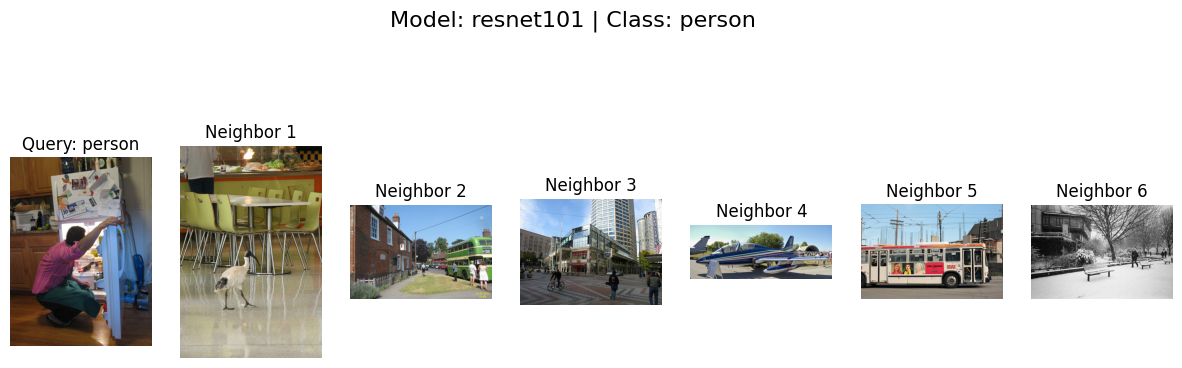

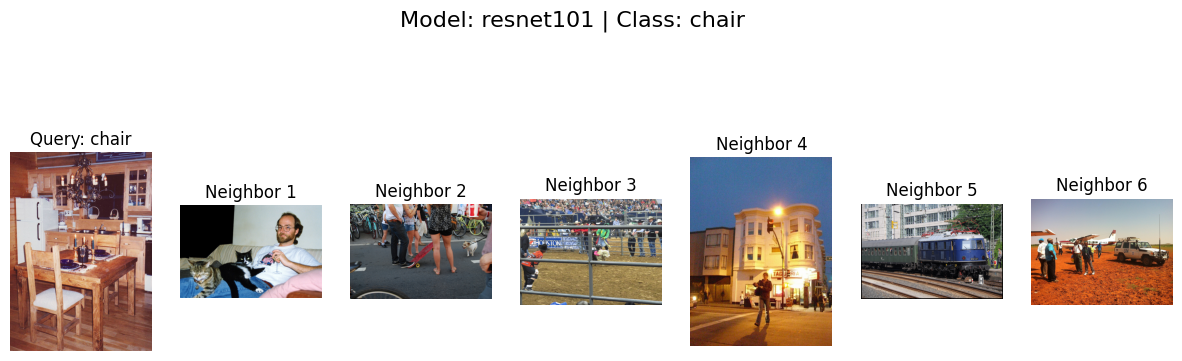

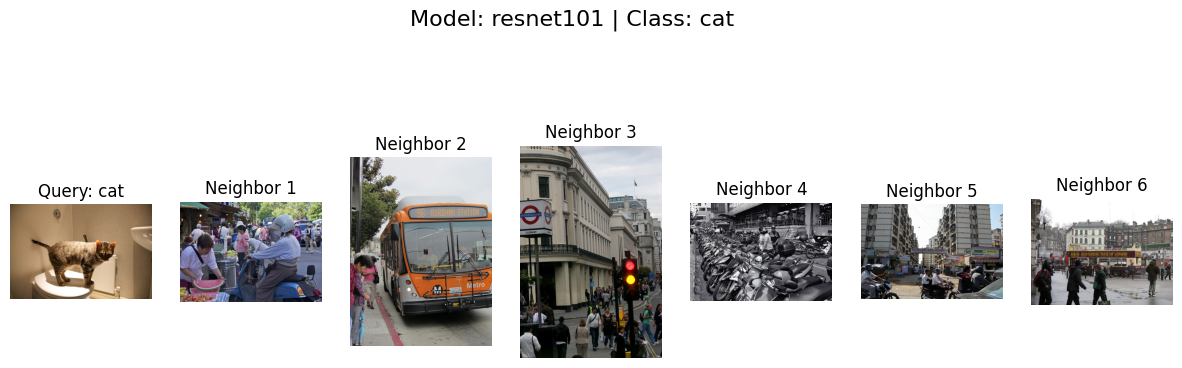

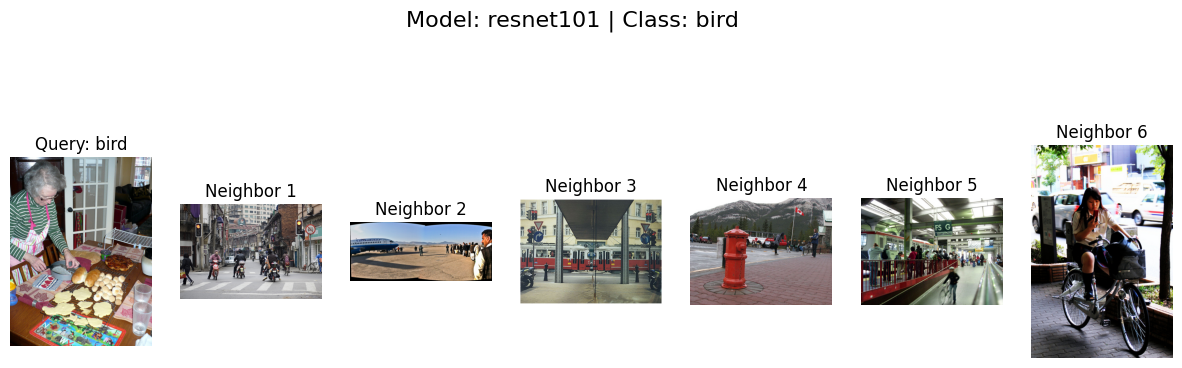

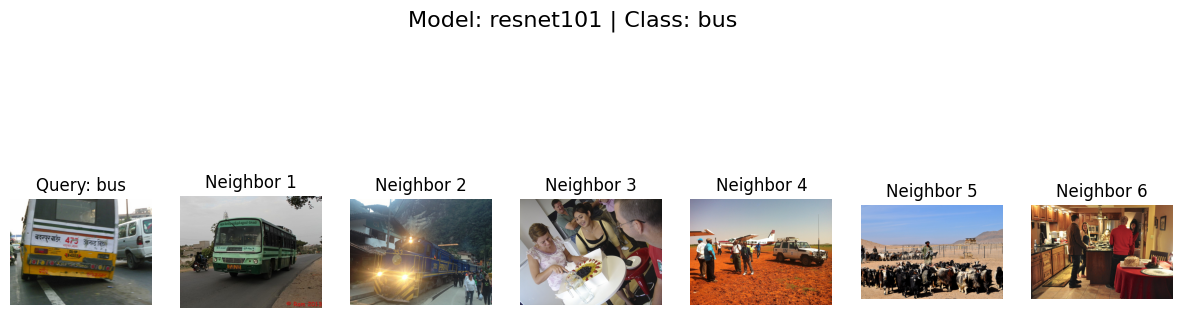

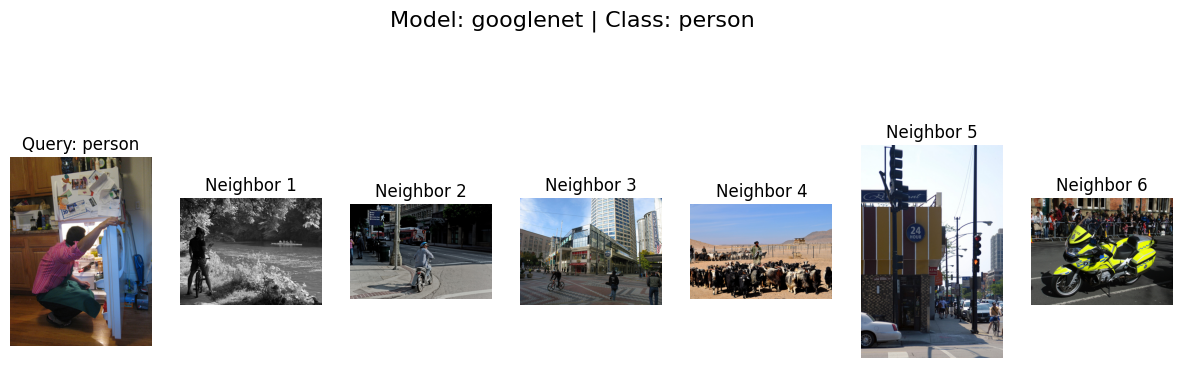

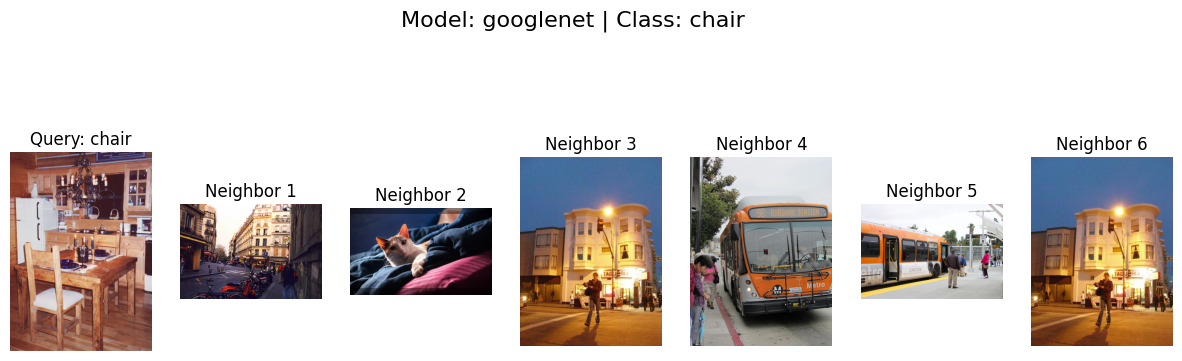

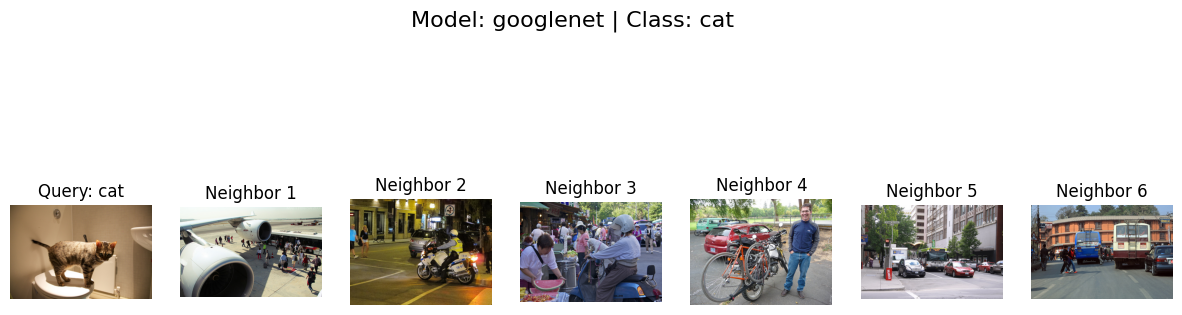

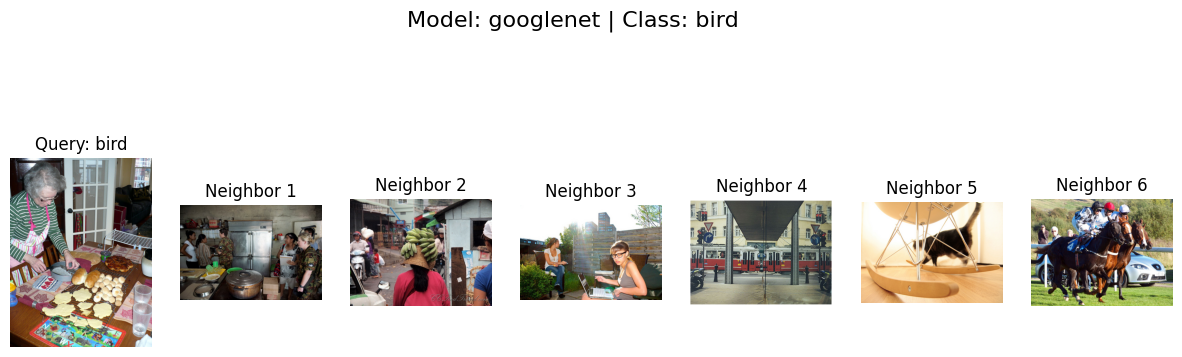

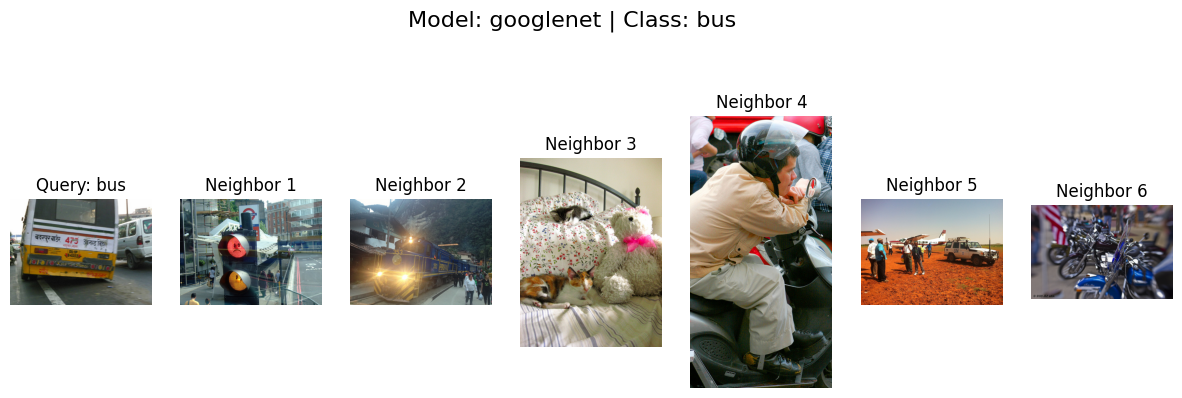

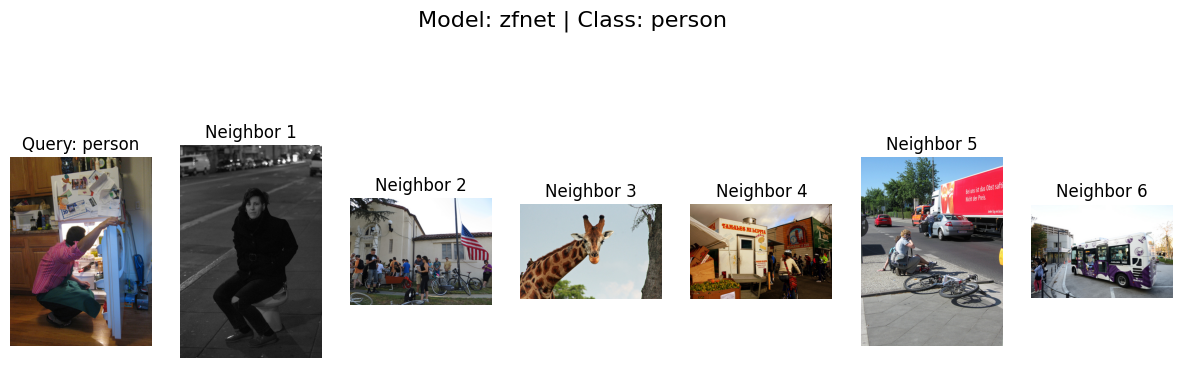

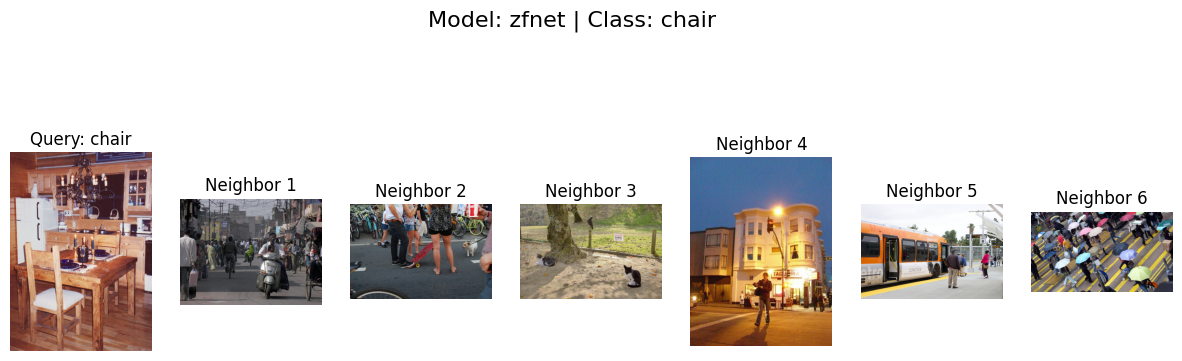

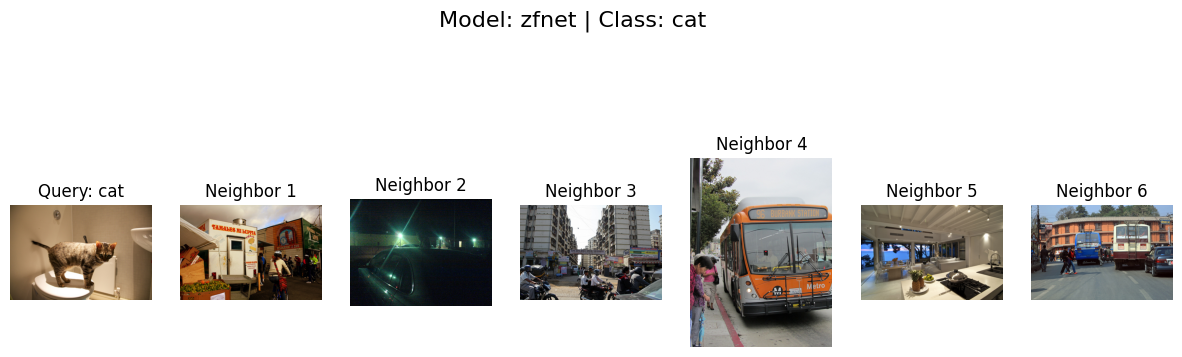

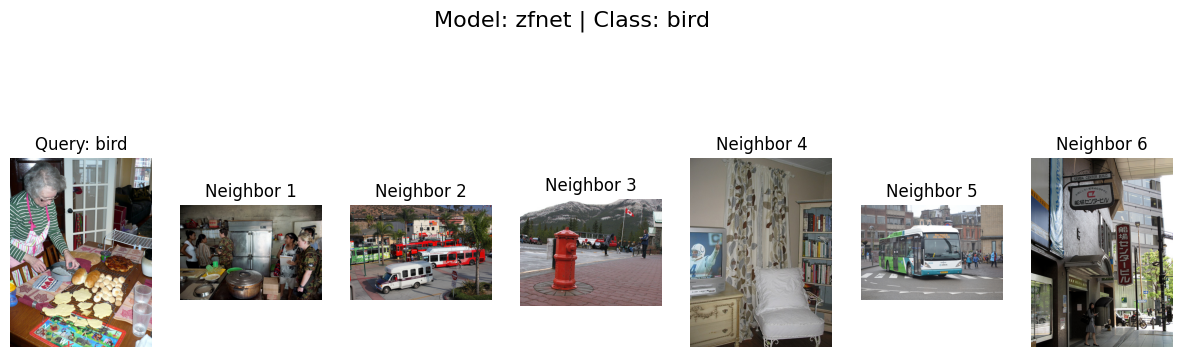

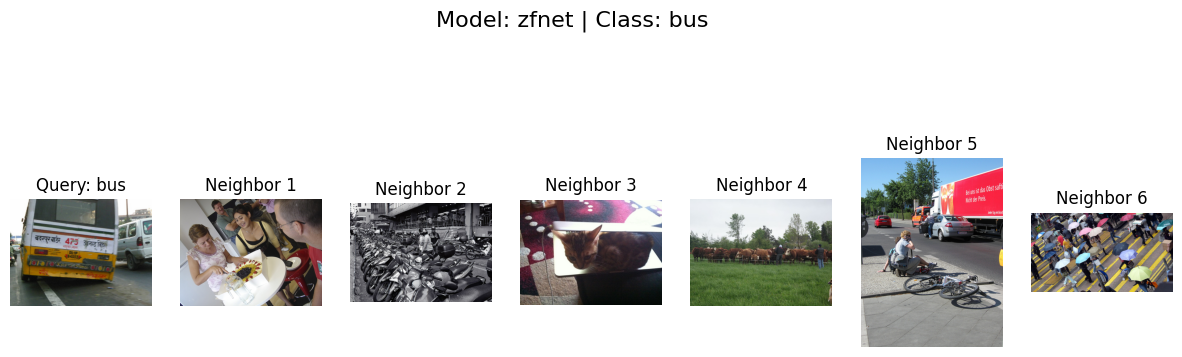

In [60]:
import matplotlib.pyplot as plt
import cv2  # To read images
import numpy as np

def show_query_and_neighbors(model_name, cls, query_idx, neighbors, image_paths):
    fig, axes = plt.subplots(1, len(neighbors) + 1, figsize=(15, 5))

    # Load and display the query image
    query_image = cv2.imread(image_paths[query_idx])
    query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
    axes[0].imshow(query_image)
    axes[0].set_title(f"Query: {cls}")
    axes[0].axis("off")

    # Load and display nearest neighbor images
    for i, neighbor_idx in enumerate(neighbors):
        neighbor_image = cv2.imread(image_paths[neighbor_idx])
        neighbor_image = cv2.cvtColor(neighbor_image, cv2.COLOR_BGR2RGB)
        axes[i + 1].imshow(neighbor_image)
        axes[i + 1].set_title(f"Neighbor {i+1}")
        axes[i + 1].axis("off")

    plt.suptitle(f"Model: {model_name} | Class: {cls}", fontsize=16)
    plt.show()

# Loop through models and display images
for model_name in models_dict.keys():
    features, labels = feature_dict[model_name]

    for cls, img_idx in selected_images.items():
        neighbors = find_nearest_neighbors(features, labels, img_idx)
        show_query_and_neighbors(model_name, cls, img_idx, neighbors, image_paths)
